In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob 
from skimage.io import imread
import cv2
from PIL import Image
from skimage.transform import resize
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import save_model

In [3]:
# Loading the dataset
df = pd.read_csv('data/emotions.csv')
df

,set_id,gender,age,country
0,0,FEMALE,36,RU
1,1,FEMALE,37,RU
2,2,FEMALE,36,RU
3,3,MALE,29,RU
4,4,FEMALE,43,RU
5,5,MALE,49,RU
6,6,FEMALE,38,RU
7,7,MALE,19,PH
8,8,FEMALE,29,RU
9,9,FEMALE,32,RU


In [4]:
# Descriptive statistics of the dataset
df.describe()

,set_id,age
count,19.000000,19.000000
mean,9.000000,31.105263
std,5.627314,9.683289
min,0.000000,15.000000
25%,4.500000,22.000000
50%,9.000000,33.000000
75%,13.500000,37.000000
max,18.000000,49.000000


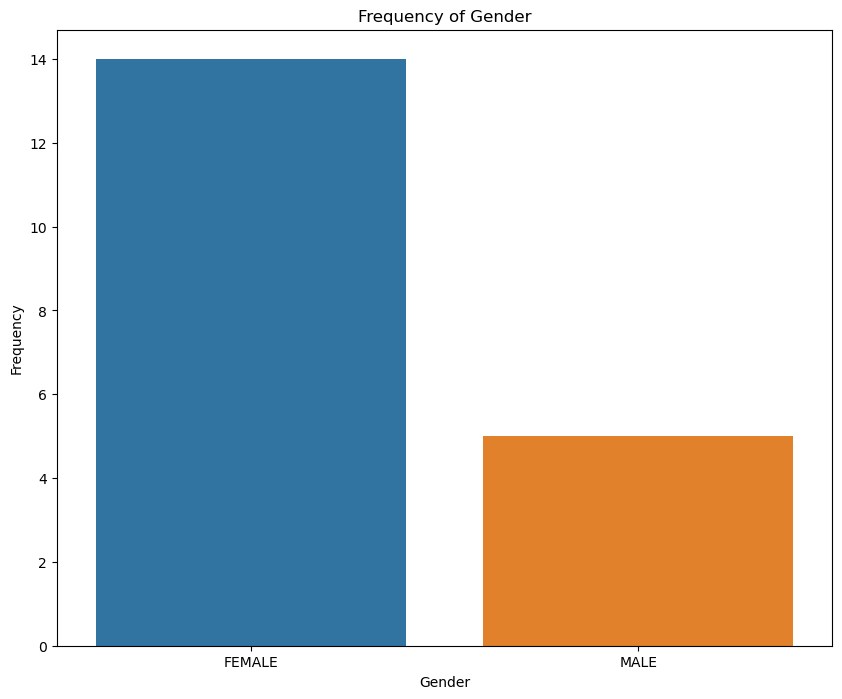

In [5]:
# Plotting the frequency of gender
plt.figure(figsize=(10, 8))
sns.barplot(x=df['gender'].value_counts().index, y=df['gender'].value_counts())
plt.title('Frequency of Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

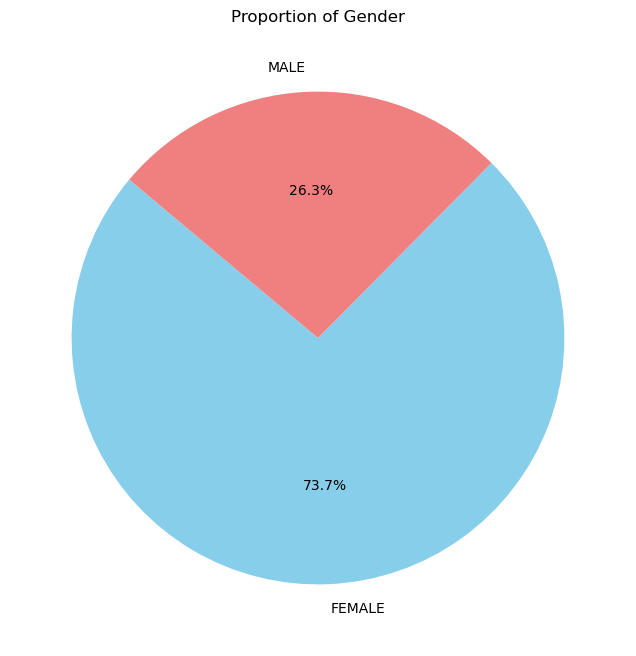

In [6]:
# Plotting the proportion of gender using a pie chart
plt.figure(figsize=(10, 8))
plt.pie(df['gender'].value_counts(), labels=df['gender'].value_counts().index, autopct='%1.1f%%', startangle=140,
        colors=['skyblue', 'lightcoral'])
plt.title('Proportion of Gender')
plt.show()

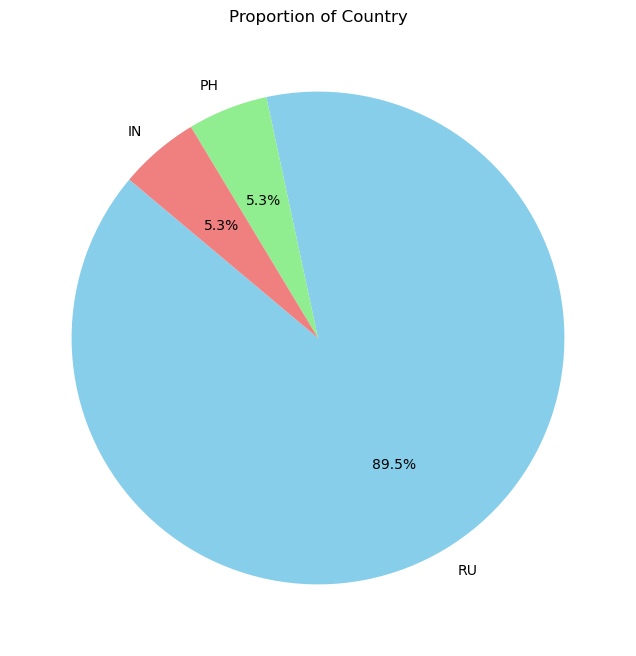

In [7]:
# Plotting the proportion of country using a pie chart
plt.figure(figsize=(10, 8))
plt.pie(df['country'].value_counts(), labels=df['country'].value_counts().index, autopct='%1.1f%%', startangle=140,
        colors=['skyblue', 'lightgreen','lightcoral'])
plt.title('Proportion of Country')
plt.show()

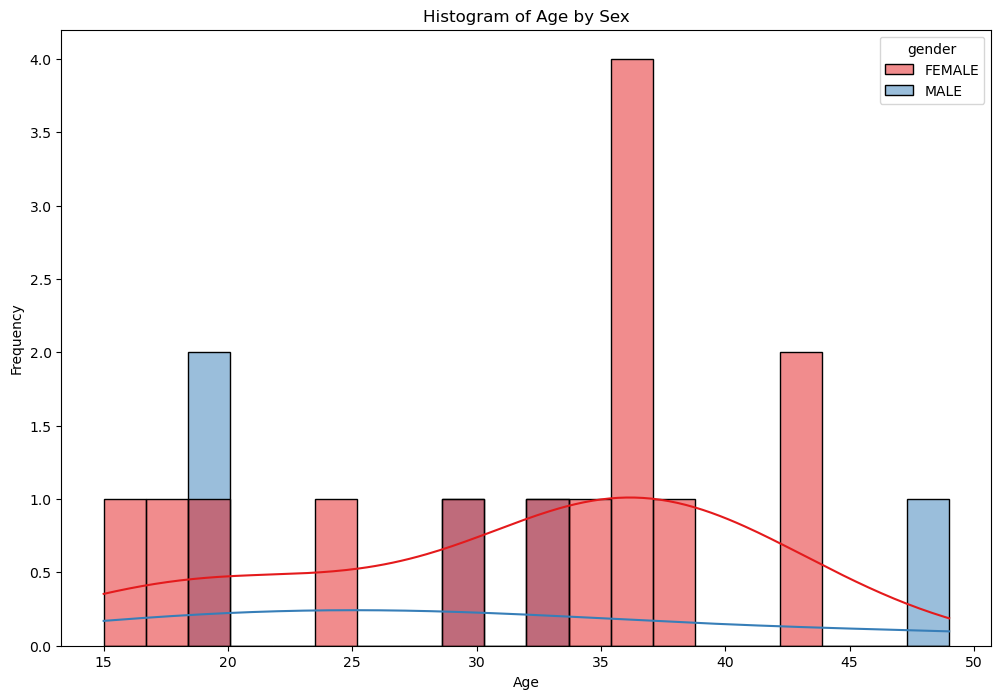

In [8]:
# Visualizing the age distribution by gender
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='age', hue='gender', palette='Set1', kde=True, bins=20)
plt.title('Histogram of Age by Sex')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x800 with 0 Axes>

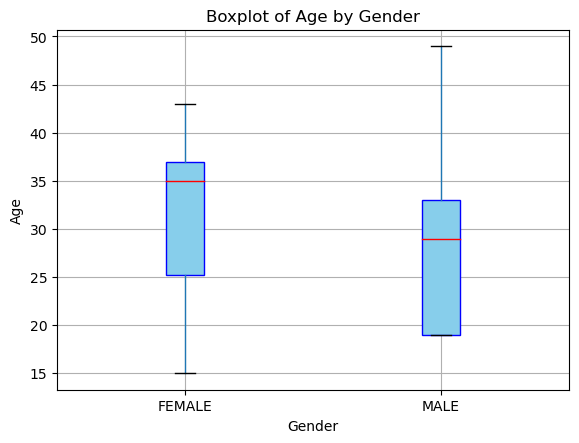

In [9]:
# Boxplot for age distribution by gender
plt.figure(figsize=(10, 8))
df.boxplot(column='age', by='gender', patch_artist=True, boxprops=dict(facecolor='skyblue', color='blue'),
           medianprops=dict(color='red'))
plt.title('Boxplot of Age by Gender')
plt.suptitle('')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

In [35]:
# Loading image paths
images = glob.glob('data/images/*/*.jpg')
print(len(images)) # Total number of images
print(images[0]) # Example path

152
data/images/18/Happy.jpg


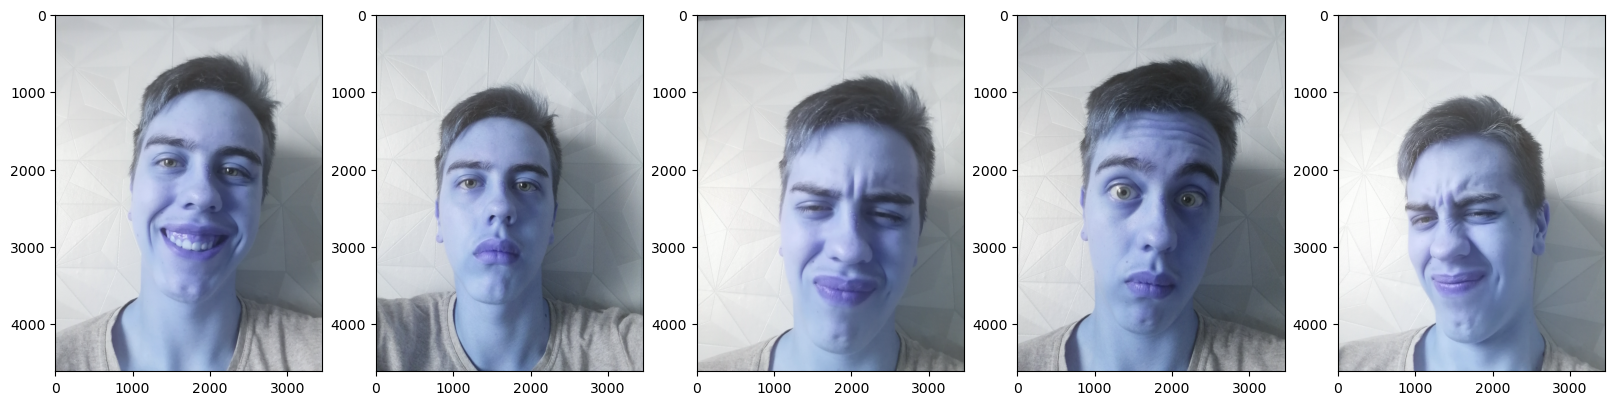

In [37]:
# Displaying some sample images
fig, axes = plt.subplots(1, 5, figsize=(20, 10))  
for i in range(5):
    img = cv2.imread(images[i])
    axes[i].imshow(img)      
plt.show()

In [100]:
# Creating a DataFrame for image paths and their respective emotions
image_data = pd.DataFrame(index=np.arange(0, len(images)), columns=['path', 'emotion'])
for i in range(len(images)):
    image_data.loc[i, 'path'] = images[i]
    image_data.loc[i, 'emotion'] = images[i][14:].replace(images[i][-4:], '')

In [102]:
image_data

,path,emotion
0,data/images/18/Happy.jpg,/Happy
1,data/images/18/Neutral.jpg,/Neutral
2,data/images/18/Sad.jpg,/Sad
3,data/images/18/Surprised.jpg,/Surprised
4,data/images/18/Disgust.jpg,/Disgust
...,...,...
147,data/images/14/Surprised.jpg,/Surprised
148,data/images/14/Disgust.jpg,/Disgust
149,data/images/14/Anger.jpg,/Anger
150,data/images/14/Fear.jpg,/Fear


In [104]:
# Standardizing the emotion column values by removing unnecessary prefixes to ensure consistency in emotion labels.
image_data['emotion'] = image_data['emotion'].replace('/Surprised', 'Surprised')
image_data['emotion'] = image_data['emotion'].replace('/Happy', 'Happy')
image_data['emotion'] = image_data['emotion'].replace('/Sad', 'Sad')
image_data['emotion'] = image_data['emotion'].replace('/Anger', 'Anger')
image_data['emotion'] = image_data['emotion'].replace('/Neutral', 'Neutral')
image_data['emotion'] = image_data['emotion'].replace('/Fear', 'Fear')
image_data['emotion'] = image_data['emotion'].replace('/Contempt', 'Contempt')
image_data['emotion'] = image_data['emotion'].replace('/Disgust', 'Disgust')

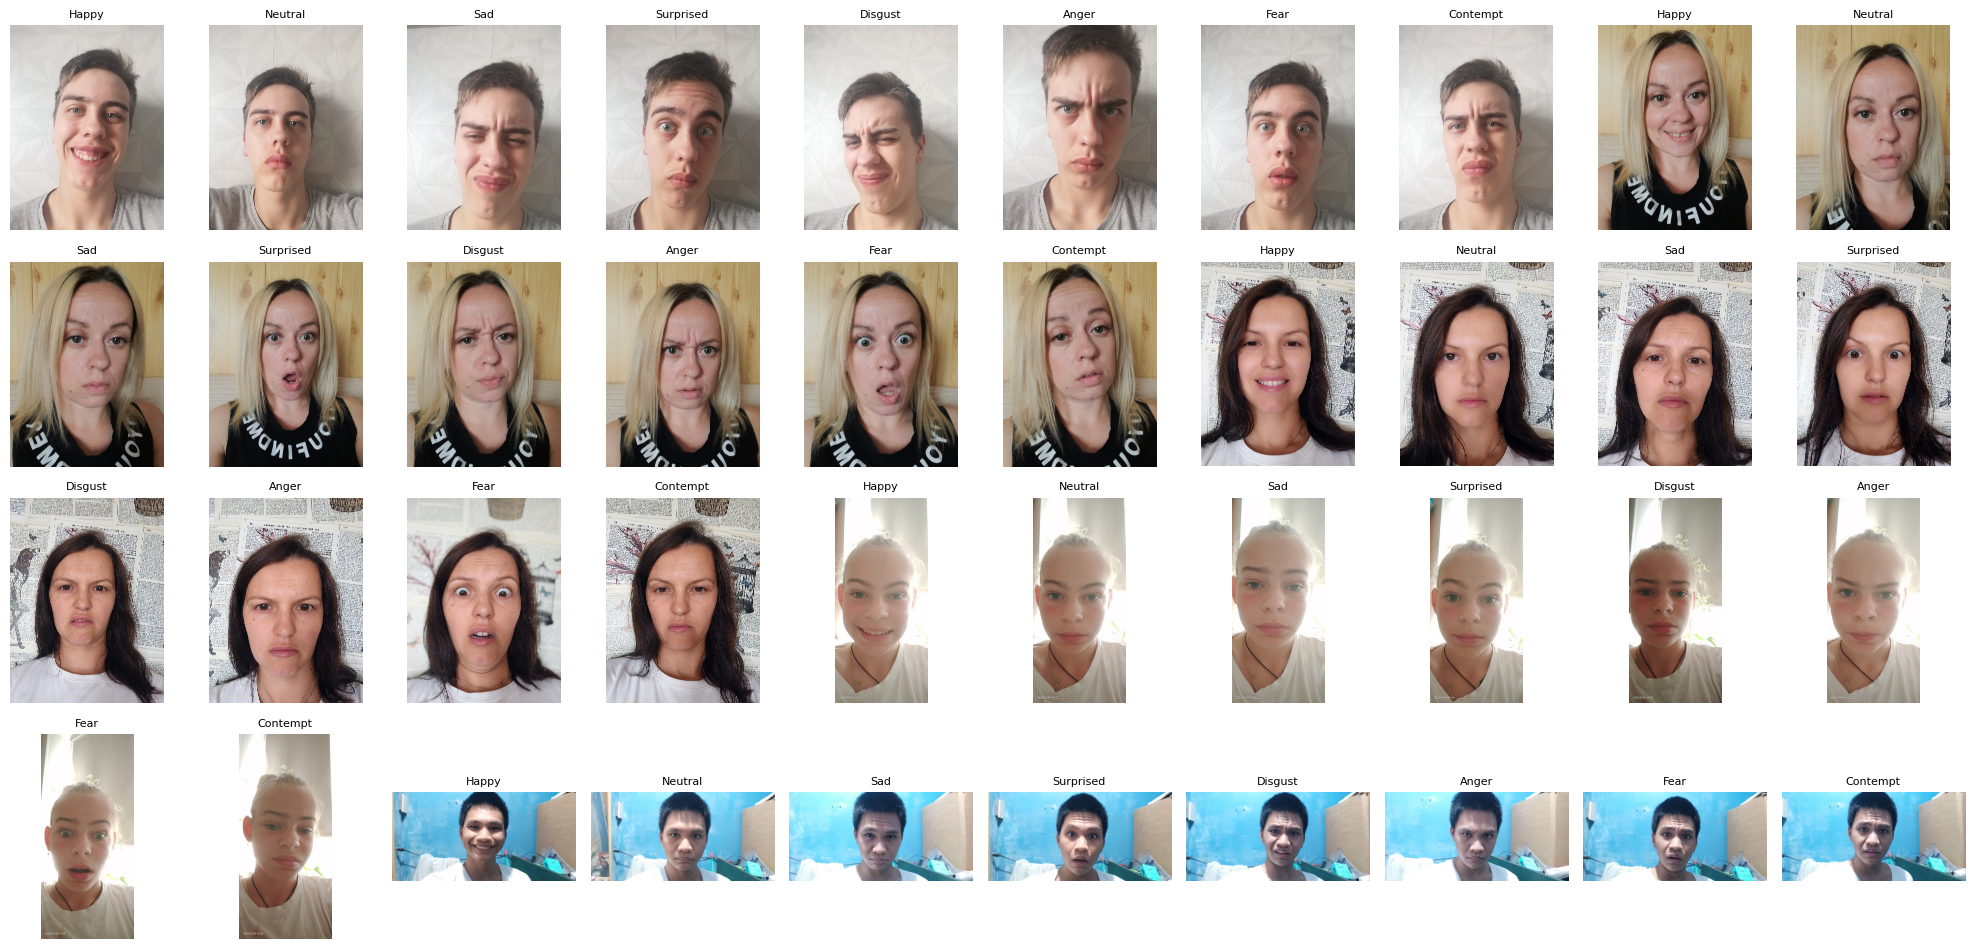

In [106]:
# Displaying a grid of 40 images (4 rows and 10 columns) with their corresponding emotion labels
fig, axes = plt.subplots(4, 10, figsize=(20, 10))
for i in range(4):
    for j in range(10):        
        image = imread(image_data.iloc[j + 10*i]["path"])
        axes[i, j].imshow(image)
        label = image_data.iloc[j + 10*i]["emotion"]
        axes[i, j].set_title(label, fontsize=8) 
        axes[i, j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

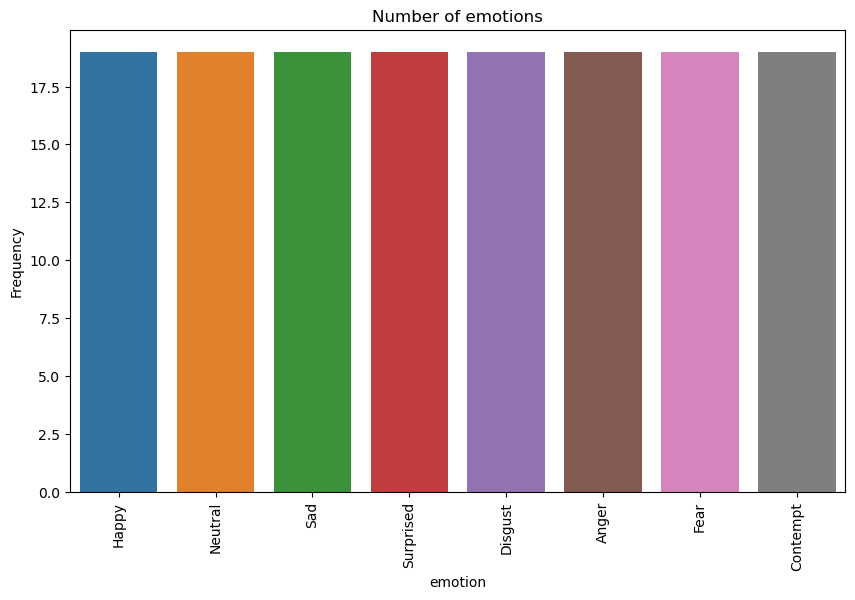

In [107]:
# Plotting the distribution of emotions to visualize the frequency of each emotion label in the dataset
plt.figure(figsize=(10, 6))
sns.barplot(x=image_data['emotion'].value_counts().index, y=image_data['emotion'].value_counts())
plt.title('Number of emotions')
plt.xlabel('emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [110]:
# Encoding the emotion labels as integers using LabelEncoder
label_encoder = LabelEncoder()
image_data['emotion'] = label_encoder.fit_transform(image_data['emotion'])

In [112]:
image_data

,path,emotion
0,data/images/18/Happy.jpg,4
1,data/images/18/Neutral.jpg,5
2,data/images/18/Sad.jpg,6
3,data/images/18/Surprised.jpg,7
4,data/images/18/Disgust.jpg,2
...,...,...
147,data/images/14/Surprised.jpg,7
148,data/images/14/Disgust.jpg,2
149,data/images/14/Anger.jpg,0
150,data/images/14/Fear.jpg,3


In [114]:
# Loading and resizing images to 224x224 pixels and preparing feature (X) and label (y) arrays
X = []
y = []
for feature, label in image_data.values:
    image = cv2.imread(feature)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
    X.append(image)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [115]:
# Print shape of input data (X) and output data (y)
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (152, 224, 224, 3)
Shape of y: (152,)


In [116]:

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest'       
)

In [117]:
# Applying augmentation to images
augmented_X = []
augmented_y = []
for i in range(len(X)):
    img = X[i].reshape((1, *X[i].shape))  
    label = y[i]
    for _ in range(50):  
        augmented = next(datagen.flow(img, batch_size=1))
        augmented_X.append(augmented[0])  
        augmented_y.append(label)        
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

In [118]:
# Combining original and augmented data
X = np.concatenate([X, augmented_X], axis=0)
y = np.concatenate([y, augmented_y], axis=0)

In [119]:
# Print shape of input data (X) and output data (y) after augmentation
print(X.shape)  
print(y.shape)

(7752, 224, 224, 3)
(7752,)


In [120]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [121]:
print(f'Length of Training Data: {len(X_train)}')
print(f'Length of Testing Data: {len(X_test)}')

Length of Training Data: 6201
Length of Testing Data: 1551


In [122]:
y_train = to_categorical(y_train, num_classes = 8)
y_test = to_categorical(y_test, num_classes = 8)

In [123]:
# Building the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, mode='max', verbose=1, factor=0.5, min_lr=0.0001)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')
])

In [124]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [125]:
# Training the model
history = model.fit(
    X_train, y_train, batch_size=20, validation_data=(X_test, y_test), epochs=25, callbacks=[early_stopping, lr_reduction]
)

Epoch 1/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 227s 721ms/step - accuracy: 0.1758 - loss: 2.1962 - val_accuracy: 0.4436 - val_loss: 1.5931 - learning_rate: 0.0010
Epoch 2/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 222s 715ms/step - accuracy: 0.4382 - loss: 1.4766 - val_accuracy: 0.5525 - val_loss: 1.1877 - learning_rate: 0.0010
Epoch 3/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.6385 - loss: 0.9866 - val_accuracy: 0.6074 - val_loss: 1.0291 - learning_rate: 0.0010
Epoch 4/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.7398 - loss: 0.7141 - val_accuracy: 0.7885 - val_loss: 0.5646 - learning_rate: 0.0010
Epoch 5/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.8415 - loss: 0.4414 - val_accuracy: 0.8195 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 6/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.8857 - loss: 0.3239 - val_accuracy: 0.8298 - val_loss: 0.4620 - learning_rate: 0.0010
Epoch 7/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.9234 - lo

In [126]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

49/49 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9541 - loss: 0.1496
Test Accuracy: 0.9555125832557678
Loss: 0.15994729101657867


In [127]:
# Classification report
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

49/49 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       179
           1       0.98      0.97      0.97       215
           2       0.98      0.97      0.98       184
           3       0.95      0.98      0.96       176
           4       0.90      0.99      0.94       203
           5       0.96      0.93      0.95       206
           6       0.98      0.95      0.96       194
           7       0.95      0.94      0.95       194

    accuracy                           0.96      1551
   macro avg       0.96      0.96      0.96      1551
weighted avg       0.96      0.96      0.96      1551



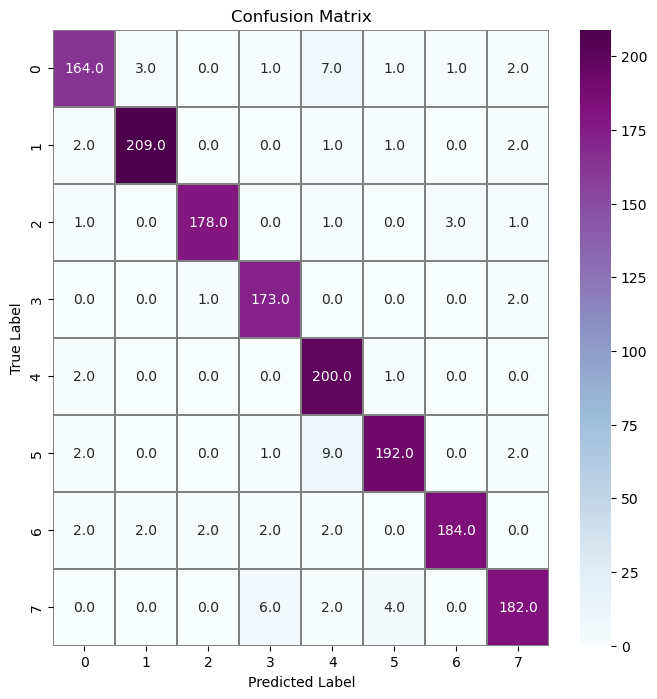

In [128]:
# Confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

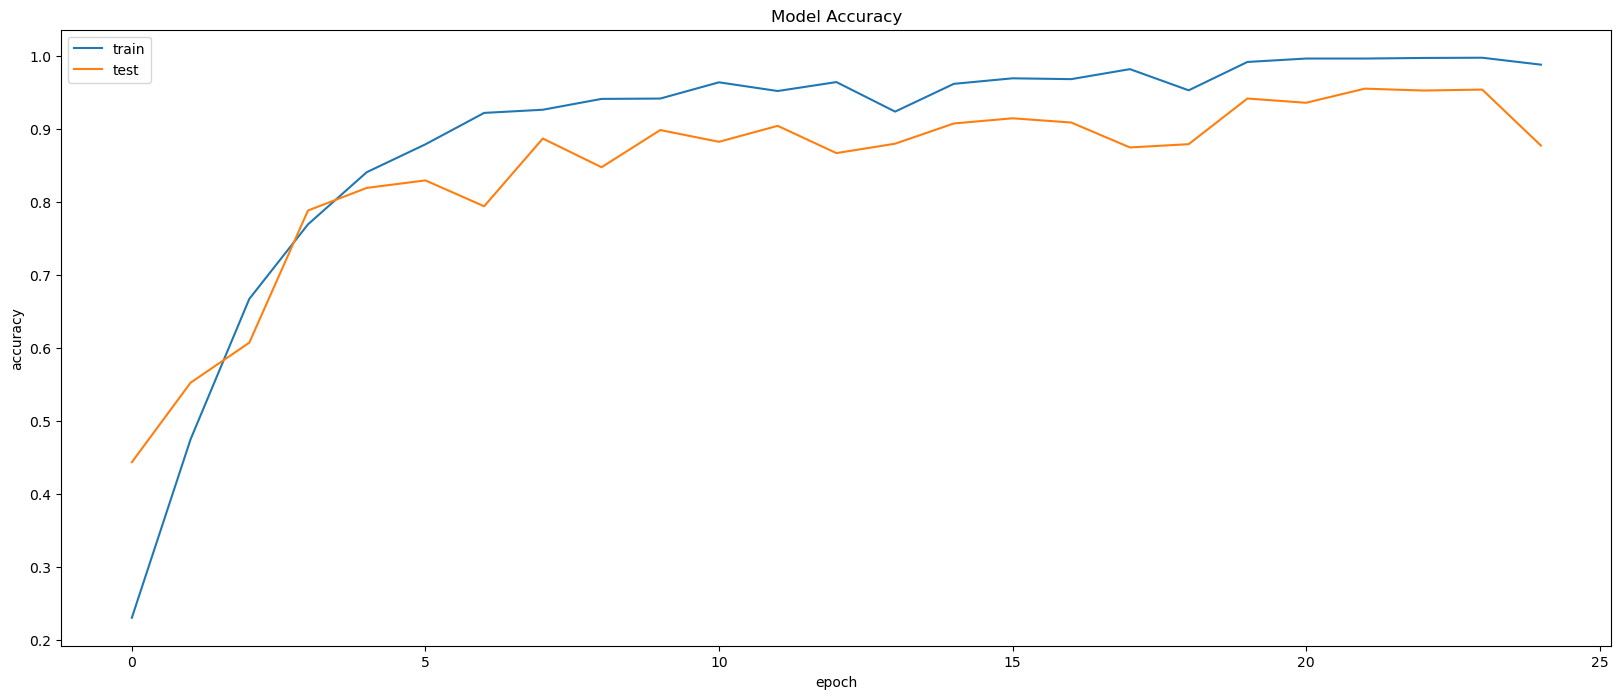

In [129]:
# Accuracy plot
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

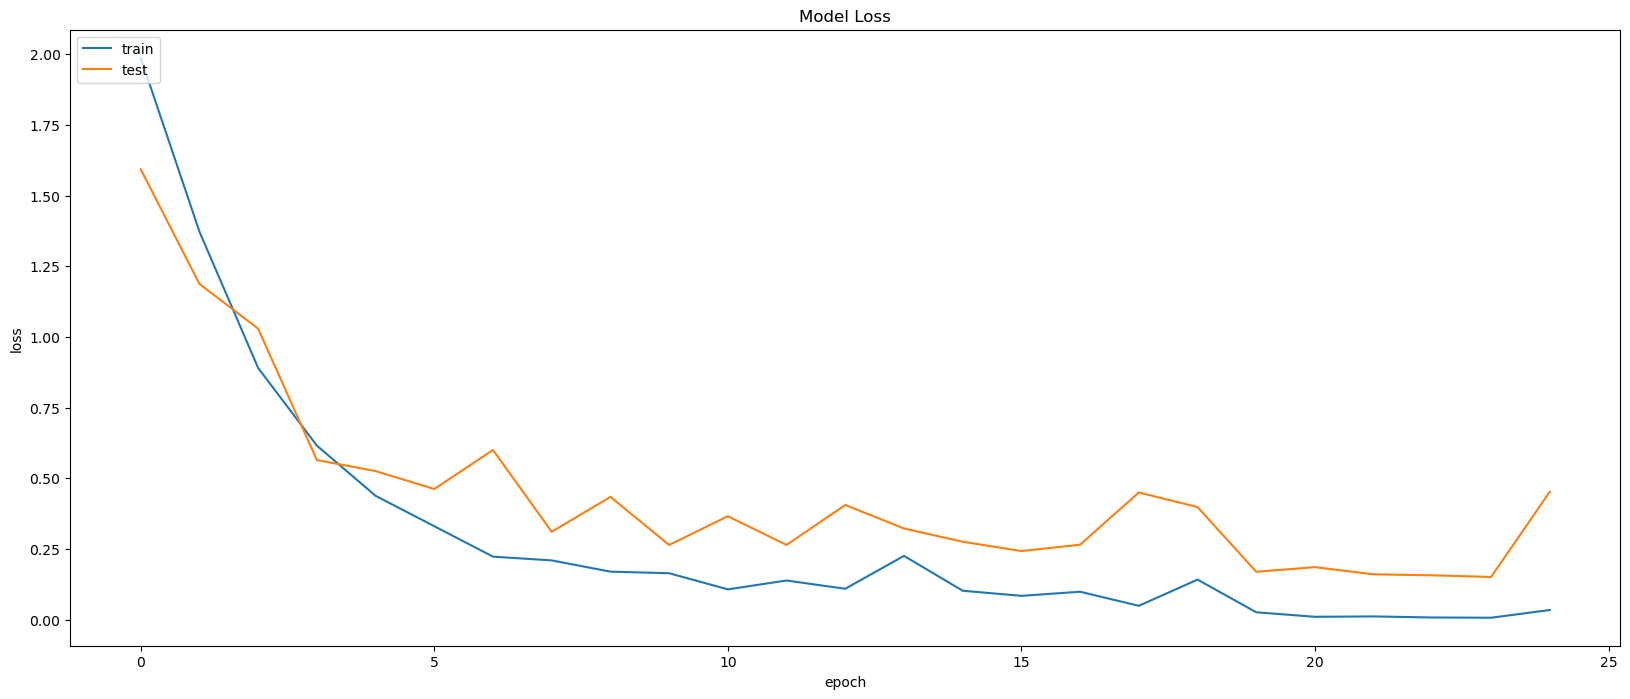

In [130]:
# Loss plot
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import save_model

save_model(model, 'models/emotion_recognition_model.h5')